In [110]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, adjusted_rand_score, homogeneity_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.svm import SVC
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.manifold import TSNE

from scipy.stats import kurtosis

In [28]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.3,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

scaler_cred_full = StandardScaler()
scaler_cred_full.fit(X_cred)
X_cred = pd.DataFrame(scaler_cred_full.transform(X_cred), index=y_cred.index)


X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)
X_mnist = pd.DataFrame(X_mnist / 255.0, index=y_mnist.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}
cred_full = {"X": X_cred, "y": y_cred, "name": "Credit Full"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}
mnist_full = {"X": X_mnist, "y": y_mnist, "name": "MNIST Full"}

In [3]:
def build_kmeans_elbow_data(data_set, max_k=15):
    X, y, name = get_data(data_set)
    
    km_scores= []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
        
    print("="*100)
    for i in range(2,max_k):
        print("Clusters: ", i)

        km = KMeans(n_clusters=i,
                    init="k-means++",
                    n_jobs=-1,
                    verbose=2,
                    precompute_distances=True,
                    random_state=random_state).fit(X)
        preds = km.predict(X)
    
        # Kmeans score
        print("K-means score:        {}".format(km.score(X)))
        km_scores.append(-km.score(X))

        # Silhouette score
        silhouette = silhouette_score(X,preds)
        km_silhouette.append(silhouette)
        print("Silhouette score:     {}".format(silhouette))
    
        # Davies Boulding score
        db = davies_bouldin_score(X,preds)
        db_score.append(db)
        print("Davies Bouldin score: {}".format(db))
    
        # V-measure score   
        v_measure = v_measure_score(y.values.ravel(), preds)
        vmeasure_score.append(v_measure)
        print("V-measure score:      {}".format(v_measure))
        print("-"*100)
    
    return (km_scores, km_silhouette, vmeasure_score, db_score)

In [4]:
def build_kmeans_plots(title, k, s, v, d, clusters=None):
    if clusters is None:
        clusters = range(2, len(k) + 2)
        
    _, axes = plt.subplots(1, 4, figsize=(28, 7))
    
    axes[0].set_title(title + " - K-means Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("K-means Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, k, '-o')
    
    axes[1].set_title(title + " - Silhouette Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Silhouette Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, s, '-o')
   
    axes[2].set_title(title + " - Davies Boulding Score")
    axes[2].set_xlabel("Clusters")
    axes[2].set_ylabel("Davies Boulding Score")
    axes[2].set_xticks(clusters)
    axes[2].grid()
    axes[2].plot(clusters, d, '-o')

    axes[3].set_xlabel("Clusters")
    axes[3].set_ylabel("V-measure score")
    axes[3].set_xticks(clusters)
    axes[3].grid()
    axes[3].plot(clusters, v, '-o')
    
    plt.show()

In [5]:
def show_digits(data_set, digit_ids, title):
    X, y, name = get_data(data_set)
    
    fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True)
    fig.set_figheight(7)
    fig.set_figwidth(7)
    fig.suptitle(title, fontsize=12)

    image_id = 0
    for i in range(10):
        for j in range(10):
            axes[i][j].imshow(X.loc[digit_ids[image_id], :].values.reshape([28,28]), cmap=plt.get_cmap('gray'))
            axes[i][j].xaxis.set_major_locator(plt.NullLocator())
            axes[i][j].yaxis.set_major_locator(plt.NullLocator())

            image_id += 1

In [6]:
def cumulative_variance_pca(pca, title, percentile=0.9):
    cum_var = []
    sum = 0
    count = 0
    x_marker = 0
    for ratio in pca.explained_variance_ratio_:
        sum += ratio
        if sum >= percentile:
            x_marker = count
        else:
            count += 1
            
        cum_var.append(sum)

    y_marker = cum_var[x_marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")

    plt.title(title + " - {}% Variance Explained by Top {} Components".format(int(percentile * 100), x_marker))
    plt.plot(range(len(pca.explained_variance_ratio_)), cum_var, label="Cumulative Variance")
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Variance")
    plt.ylabel("% Variance Explained")
    plt.xlabel("Top n components used")
    plt.legend(loc="best")
    plt.show()

In [116]:
def two_comp_scatter(X, yDF, title):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title(title)

In [8]:
def select_comp_scatter(X, yDF, c1, c2, algo):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,[c1, c2]], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations - {}".format(algo))

In [9]:
def dominant_component(comps):
    return {
        "comp, feat": list(zip(range(len(comps)),list(np.argmax(comps, axis=1)))),
        "feat, comp": list(zip(range(len(comps[0])),list(np.argmax(comps, axis=0))))
    }

In [10]:
def mse(data, reconstruction):
    return np.mean(((data - reconstruction) ** 2).values)

In [11]:
def rp_reconstruction(transformed, components):
    return np.dot(transformed, np.linalg.pinv(components.T))

In [12]:
def rp_svm_cross_val(data, n_comp, random_state, scoring):
    X, y, _ = get_data(data)
    
    rp = GaussianRandomProjection(n_components=n_comp, random_state=random_state)
    transformed = rp.fit_transform(X)
    csvm = SVC(C=5,gamma=0.01,kernel='rbf',cache_size=60000,random_state=random_state)
    scores = cross_val_score(csvm, transformed, y, cv=5, scoring=scoring, n_jobs=-1, pre_dispatch="2*n_jobs")
    
    return np.mean(scores)

In [13]:
def rp_comp_error(data, n_comp, runs=10):
    X, y, _ = get_data(data)

    def run(i, error):
        rp = GaussianRandomProjection(n_components=n_comp, random_state=i)
        transformed = rp.fit_transform(X)
        reconstructed = rp_reconstruction(transformed, rp.components_)
        error.append(mse(X, reconstructed))
    
    error = []
    for i in range(runs):
        run(i, error)

    error_mean = np.mean(error)
    error_std = np.std(error)
        
    return (n_comp, error_mean, error_std)

In [14]:
def recon_error_plot(recon_error, title, error=0.1):
    x = [tup[0] for tup in recon_error]
    e_mean = np.array([tup[1] for tup in recon_error])
    e_std = np.array([tup[2] for tup in recon_error])
    
    marker = 0
    for i in range(len(e_mean)):
        if e_mean[i] >= error:
            marker = i
    y_marker = e_mean[marker]
    x_marker = x[marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")
    title += "\n{} Mean Square Error with {} Components".format(round(y_marker, 3), x_marker)
    
    plt.title(title)
    plt.plot(x, e_mean, label="Reconstruction Error", lw=2)
    plt.fill_between(x, e_mean - e_std, e_mean + e_std, alpha=0.1)
    plt.ylabel("MSE")
    plt.xlabel("Components")
    plt.legend(loc="best")
    plt.show()

In [96]:
def build_gmm_data(data_set, max_k=16):
    X, y, name = get_data(data_set)

    gm_bic= []
    gm_score=[]
    
    print("="*100)
    for i in range(2,max_k):
        print("Clusters: ", i)
        gm = GaussianMixture(n_components=i
                             ,n_init=10,
                             tol=1e-3,
                             max_iter=1000).fit(X)
        print("BIC:            {}".format(gm.bic(X)))
        print("Log-likelihood: {}".format(gm.score(X)))
        print("-"*100)
        gm_bic.append(gm.bic(X))
        gm_score.append(gm.score(X))
    return (gm_bic, gm_score)

In [16]:
def build_gmm_plots(title, gm_bic, gm_score, clusters=None):
    if clusters is None:
        clusters = range(2, len(gm_bic) + 2)
        
    _, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    axes[0].set_title(title + " - BIC Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("BIC Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, gm_bic, '-o')
    
    axes[1].set_title(title + " - Log-likelihood Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Log-likelihood Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, gm_score, '-o')

In [111]:
def tSNE_transform(data, perplexity=50, n_iter=1000, scale_down=0.9):
    X = data['X']
    y = data['y']
    
    X, _, y, _ = train_test_split(X, y, test_size=scale_down,random_state=random_state,stratify=y)
    
    return TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, n_jobs=-1).fit_transform(X)

# K-means Credit

## PCA

In [30]:
Xc, yc, _ = get_data(cred_full)
pca_cred = PCA(n_components=12, random_state=random_state)
X_cred_pca = pca_cred.fit_transform(Xc)

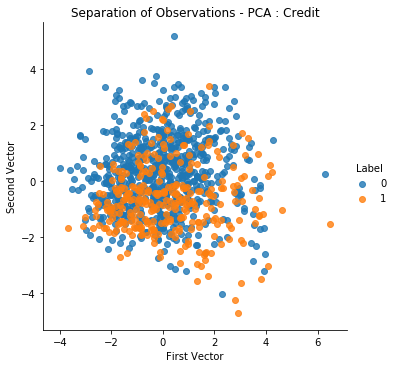

In [31]:
two_comp_scatter(X_cred_pca, yc, "PCA : Credit")

In [32]:
cred_pca = {"X": X_cred_pca, "y": y_cred, "name": "Credit PCA"}
cred_pca_bic, cred_pca_score = build_gmm_data(cred_pca)

Clusters:  2
BIC:            33568.53178204075
Log-likelihood: -16.15911403827249
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            31827.503133586353
Log-likelihood: -14.974296848851605
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            30999.252702005142
Log-likelihood: -14.245868767867313
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            31213.17587826825
Log-likelihood: -14.03852749080518
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            31346.189376647268
Log-likelihood: -13.790731374801002
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            31514.561883472157
Log-likelihood: -13.56061476301

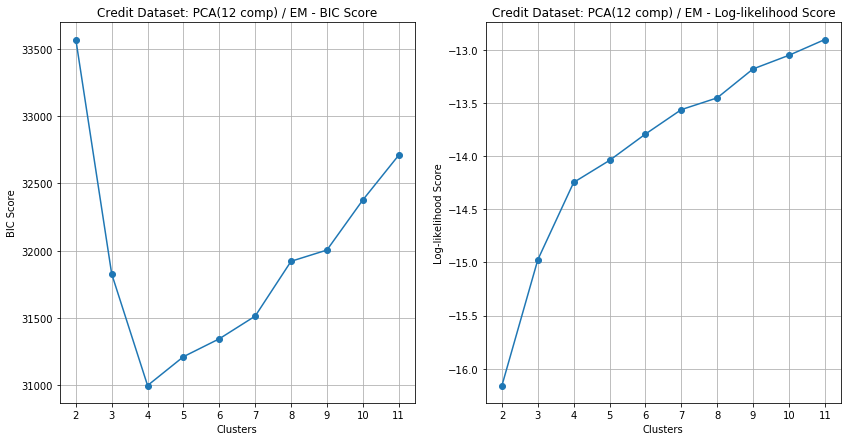

In [33]:
ctitle = "Credit Dataset: PCA(12 comp) / EM"
build_gmm_plots(ctitle, cred_pca_bic, cred_pca_score)

In [34]:
# 4 clusters Credit
Xc, yc, name = get_data(cred_pca)
gm = GaussianMixture(n_components=4,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xc)

pred = gm.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, pred))

Adjusted Rand Score:      0.005368261320192564
Homogeneity Score:        0.009593779566810578
Calinski Harabasz Score:  61.75096594846494


## ICA

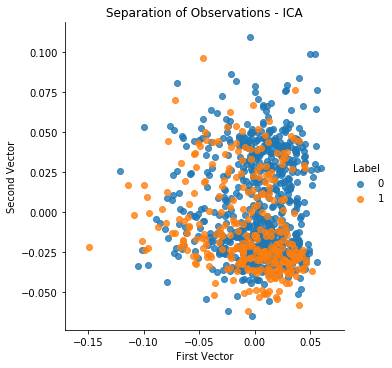

In [22]:
Xc, yc, _ = get_data(cred_full)
ica_cred = FastICA(n_components=7, whiten=True, random_state=random_state, tol=0.005)
X_cred_ica = ica_cred.fit_transform(Xc)
select_comp_scatter(X_cred_ica, yc, 1 ,6, "ICA")

In [50]:
cred_ica = {"X": X_cred_ica, "y": y_cred, "name": "Credit PCA"}
cred_ica_bic, cred_ica_score = build_gmm_data(cred_ica)

Clusters:  2
BIC:            -28662.564318557255
Log-likelihood: 14.576507471682493
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            -28758.878802337582
Log-likelihood: 14.749004308594337
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            -28822.951988747536
Log-likelihood: 14.905380496820992
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            -28709.44475538354
Log-likelihood: 14.972966475160673
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            -28570.87272545489
Log-likelihood: 15.028020055218025
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            -28452.89012823538
Log-likelihood: 15.0933683516

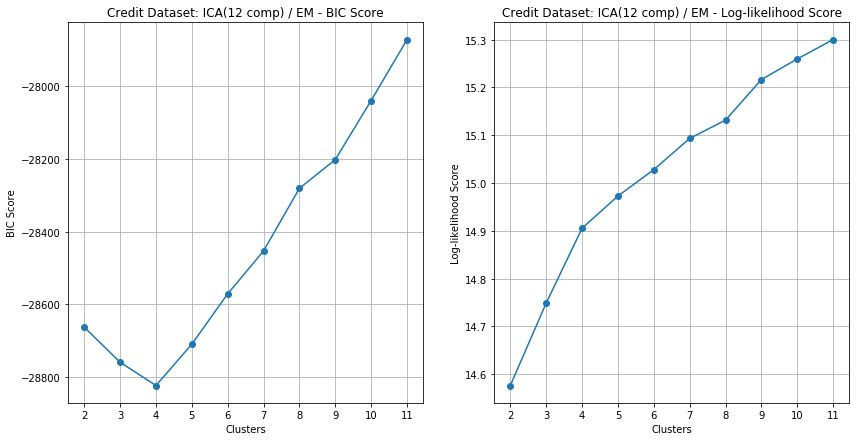

In [51]:
ctitle = "Credit Dataset: ICA(12 comp) / EM"
build_gmm_plots(ctitle, cred_ica_bic, cred_ica_score)

In [52]:
# 4 clusters Credit
Xc, yc, name = get_data(cred_ica)
gm = GaussianMixture(n_components=4,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xc)

pred = gm.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, pred))

Adjusted Rand Score:      -0.0028245181012679778
Homogeneity Score:        0.02012722581089187
Calinski Harabasz Score:  90.68862975606518


# Random Projection

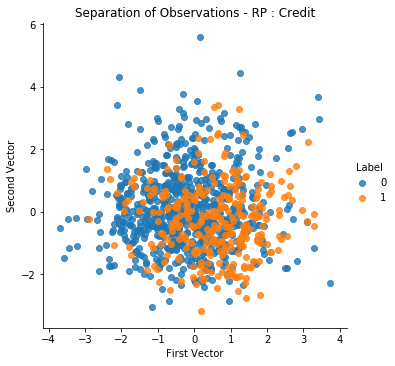

In [53]:
Xc, yc, _ = get_data(cred_full)
cred_rp = GaussianRandomProjection(n_components=12, random_state=random_state)
X_cred_rp = cred_rp.fit_transform(Xc)
two_comp_scatter(X_cred_rp, yc, "RP : Credit")

In [54]:
cred_rp = {"X": X_cred_rp, "y": y_cred, "name": "Credit Random Projection"}
cred_rp_bic, cred_rp_score = build_gmm_data(cred_rp)

Clusters:  2
BIC:            32939.85026074185
Log-likelihood: -15.844773277623043
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            32411.11332426419
Log-likelihood: -15.266101944190524
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            32528.020769158466
Log-likelihood: -15.010252801443976
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            32859.09377267757
Log-likelihood: -14.861486438009837
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            33200.444862105964
Log-likelihood: -14.71785911753035
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            33367.415286231204
Log-likelihood: -14.48704146439

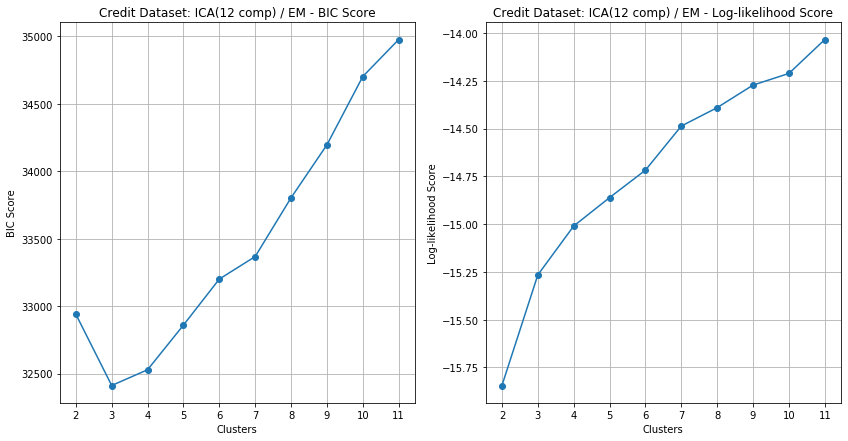

In [55]:
ctitle = "Credit Dataset: ICA(12 comp) / EM"
build_gmm_plots(ctitle, cred_rp_bic, cred_rp_score)

In [58]:
# 3 clusters Credit
Xc, yc, name = get_data(cred_rp)
gm = GaussianMixture(n_components=3,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xc)

pred = gm.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, pred))

Adjusted Rand Score:      0.008772397871374038
Homogeneity Score:        0.0012077884525144725
Calinski Harabasz Score:  66.97867993916942


# Dictionary Learning

In [99]:
Xc, yc, _ = get_data(cred_full)

dl = MiniBatchDictionaryLearning(n_components=6,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
X_cred_dl = dl.fit_transform(Xc)

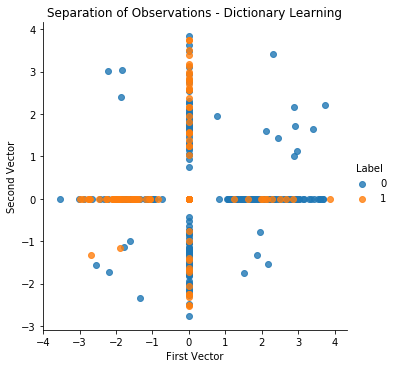

In [105]:
select_comp_scatter(cred_dl, yc, 1, 6, "Dictionary Learning")

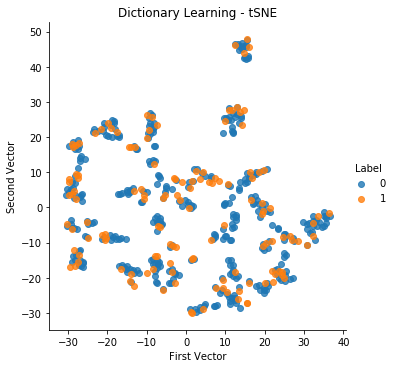

In [121]:
data = {'X': X_cred_dl, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Dictionary Learning - tSNE')

In [97]:
cred_rp = {"X": X_cred_dl, "y": yc, "name": "Credit Dictionary Learning"}
cred_rp_bic, cred_rp_score = build_gmm_data(cred_rp)

Clusters:  2
BIC:            -2071.4425925050505
Log-likelihood: 1.7575817229061586
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            -25229.17714959703
Log-likelihood: 13.699106153598711
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            -36996.57064915984
Log-likelihood: 19.945460055526677
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            -44934.99218860556
Log-likelihood: 24.2773279773961
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            -53272.296309583144
Log-likelihood: 28.808637190031455
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            -55098.04605770097
Log-likelihood: 30.0841692162369

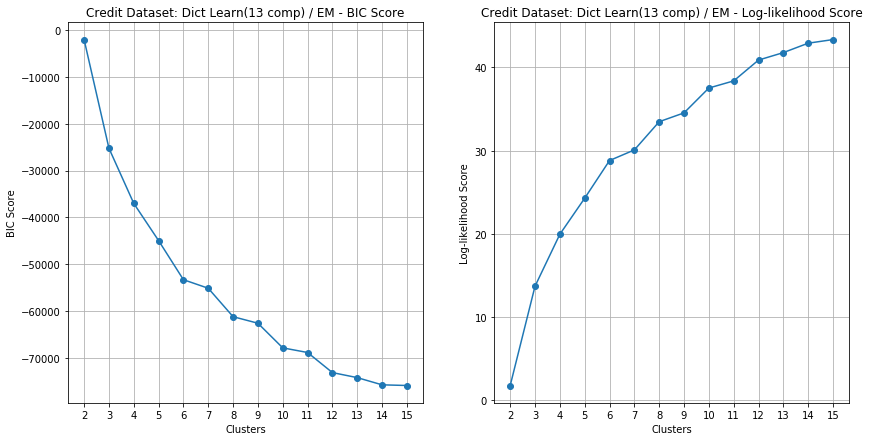

In [98]:
ctitle = "Credit Dataset: Dict Learn(13 comp) / EM"
build_gmm_plots(ctitle, cred_rp_bic, cred_rp_score)

In [103]:
# 6 clusters Credit
_, yc, name = get_data(cred_full)
gm = GaussianMixture(n_components=6,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(X_cred_dl)

pred = gm.predict(X_cred_dl)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(X_cred_dl, pred))

Adjusted Rand Score:      -0.0033144278220332926
Homogeneity Score:        0.013506572920600339
Calinski Harabasz Score:  31.012050452860265


# K-means MNIST

## PCA

In [35]:
Xm, ym, _ = get_data(mnist)
pca_mnist = PCA(n_components=153, random_state=random_state)
X_mnist_pca = pca_mnist.fit_transform(Xm)

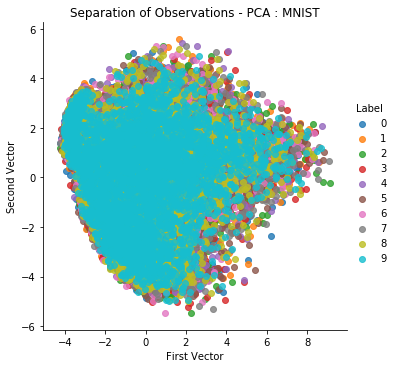

In [36]:
two_comp_scatter(X_mnist_pca, ym, "PCA : MNIST")

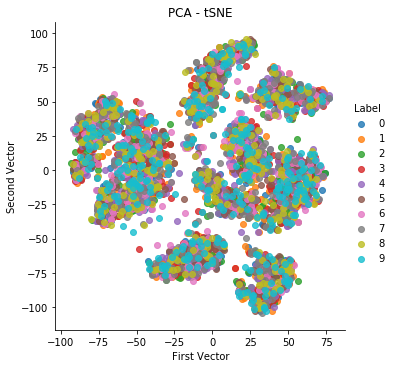

In [120]:
data = {'X': X_mnist_pca, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'PCA - tSNE')

In [43]:
mnist_pca = {"X": X_mnist_pca, "y": y_mnist_train, "name": "MNIST PCA"}
mnist_pca_bic, mnist_pca_score = build_gmm_data(mnist_pca)

Clusters:  2
BIC:            2444108.678245878
Log-likelihood: -22.309526620369905
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            949777.0989302476
Log-likelihood: -5.746011173143043
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            -810192.531960127
Log-likelihood: 13.528096637091412
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            -1176688.1555829032
Log-likelihood: 18.58308192418711
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            -2047607.2167467566
Log-likelihood: 28.78524514537543
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            -2697765.478368053
Log-likelihood: 36.734747146741746

In [64]:
pca_bic= []
pca_score=[]
X = X_mnist_pca
print("="*100)
for i in range(12,15):
    print("Clusters: ", i)
    gm = GaussianMixture(n_components=i
                         ,n_init=10,
                         tol=1e-3,
                         max_iter=1000).fit(X)
    bic = gm.bic(X)
    score = gm.score(X)
    print("BIC:            {}".format(bic))
    print("Log-likelihood: {}".format(score))
    print("-"*100)
    pca_bic.append(bic)
    pca_score.append(score)

pca_bic, pca_score

Clusters:  12
BIC:            -4569839.784658287
Log-likelihood: 62.413716318713625
----------------------------------------------------------------------------------------------------
Clusters:  13
BIC:            -4718580.082517982
Log-likelihood: 65.24670848577789
----------------------------------------------------------------------------------------------------
Clusters:  14
BIC:            -4793183.701680953
Log-likelihood: 67.323203931447
----------------------------------------------------------------------------------------------------


([-4569839.784658287, -4718580.082517982, -4793183.701680953],
 [62.413716318713625, 65.24670848577789, 67.323203931447])

In [77]:
full_pca_bic = mnist_pca_bic + [-4569839.784658287, -4718580.082517982, -4793183.701680953]
full_pca_score = mnist_pca_score + [62.413716318713625, 65.24670848577789, 67.323203931447]

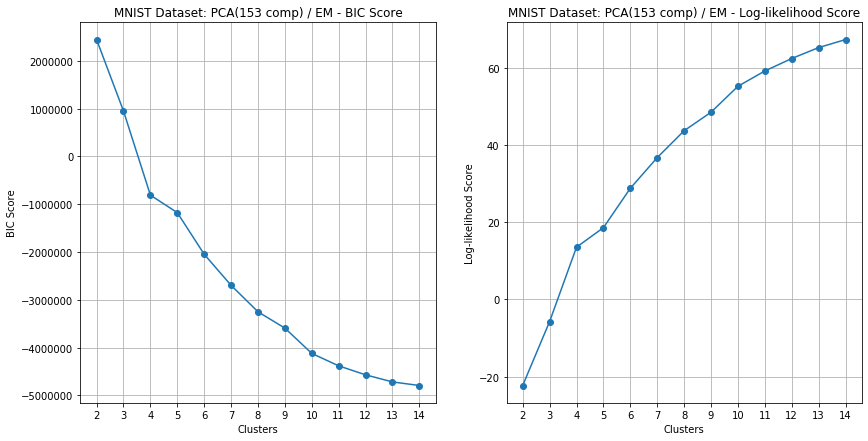

In [78]:
mtitle = "MNIST Dataset: PCA(153 comp) / EM"
build_gmm_plots(mtitle, full_pca_bic, full_pca_score)

In [59]:
# 11 clusters Credit
Xm, ym, name = get_data(mnist_pca)
gm = GaussianMixture(n_components=11,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xm)

pred = gm.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, pred))

Adjusted Rand Score:      0.30293688190560436
Homogeneity Score:        0.47395707150527994
Calinski Harabasz Score:  1368.9205994726926


## ICA

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


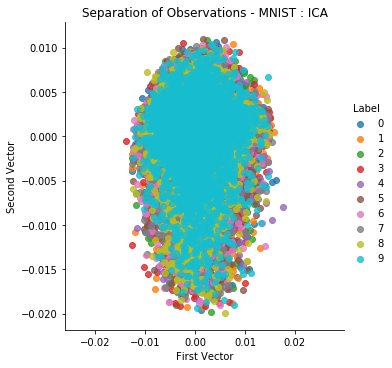

In [37]:
Xm, ym, _ = get_data(mnist)
ica_mnist = FastICA(n_components=11, whiten=True, random_state=random_state, tol=0.005)
X_mnist_ica = ica_mnist.fit_transform(Xm)
select_comp_scatter(X_mnist_ica, ym, 2 ,9, "MNIST : ICA")

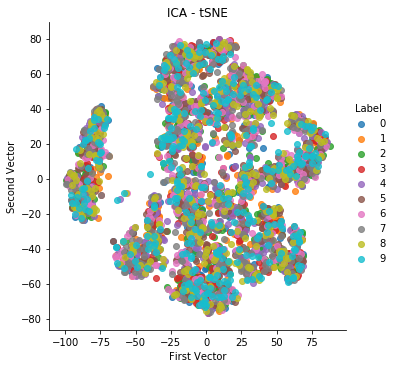

In [119]:
data = {'X': X_mnist_ica, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'ICA - tSNE')

In [44]:
mnist_ica = {"X": X_mnist_ica, "y": y_mnist_train, "name": "MNIST ICA"}
mnist_ica_bic, mnist_ica_score = build_gmm_data(mnist_ica)

Clusters:  2
BIC:            -4403467.431994282
Log-likelihood: 44.95042210417073
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            -4464796.294988189
Log-likelihood: 45.58482240915971
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            -4507316.872690937
Log-likelihood: 46.02730143566747
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            -4529674.994128745
Log-likelihood: 46.264041112533
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            -4547396.2329608565
Log-likelihood: 46.45346566076897
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            -4562253.414299403
Log-likelihood: 46.61366513253999
----

In [66]:
ica_bic= []
ica_score=[]
X = X_mnist_ica
print("="*100)
for i in range(12,15):
    print("Clusters: ", i)
    gm = GaussianMixture(n_components=i
                         ,n_init=10,
                         tol=1e-3,
                         max_iter=1000).fit(X)
    bic = gm.bic(X)
    score = gm.score(X)
    print("BIC:            {}".format(bic))
    print("Log-likelihood: {}".format(score))
    print("-"*100)
    ica_bic.append(bic)
    ica_score.append(score)

ica_bic, ica_score

Clusters:  12
BIC:            -4609216.273291766
Log-likelihood: 47.13585588220762
----------------------------------------------------------------------------------------------------
Clusters:  13
BIC:            -4613921.577967308
Log-likelihood: 47.19246477578473
----------------------------------------------------------------------------------------------------
Clusters:  14
BIC:            -4617507.2654752955
Log-likelihood: 47.237649004386775
----------------------------------------------------------------------------------------------------


([-4609216.273291766, -4613921.577967308, -4617507.2654752955],
 [47.13585588220762, 47.19246477578473, 47.237649004386775])

In [80]:
full_ica_bic = mnist_ica_bic + [-4609216.273291766, -4613921.577967308, -4617507.2654752955]
full_ica_score = mnist_ica_score + [47.13585588220762, 47.19246477578473, 47.237649004386775]

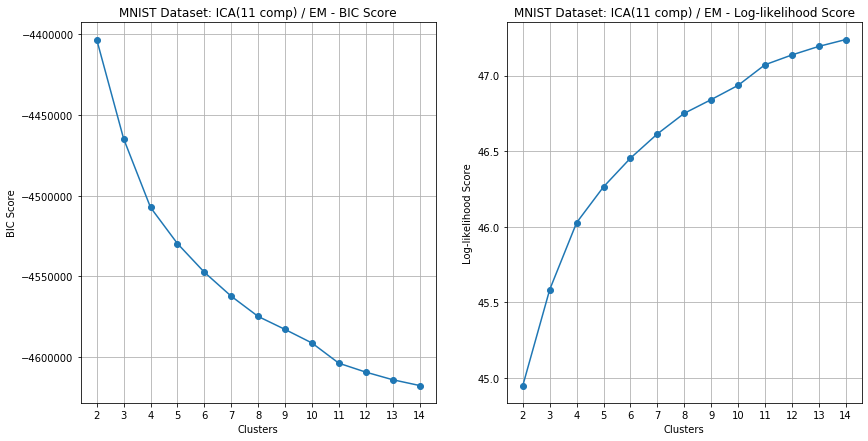

In [81]:
mtitle = "MNIST Dataset: ICA(11 comp) / EM"
build_gmm_plots(mtitle, full_ica_bic, full_ica_score)

In [122]:
# 11 clusters Credit
Xm, ym, name = get_data(mnist_ica)
gm = GaussianMixture(n_components=11,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xm)

pred = gm.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, pred))

Adjusted Rand Score:      0.503781019729859
Homogeneity Score:        0.6134275706860616
Calinski Harabasz Score:  3234.803014110012


# Random Projection

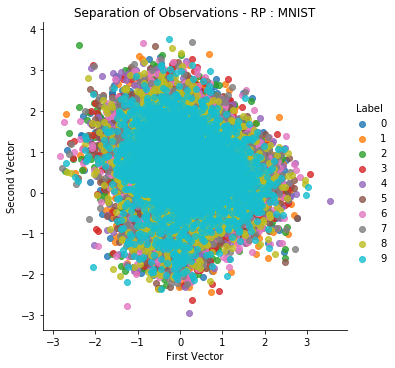

In [40]:
Xm, ym, _ = get_data(mnist)
mnist_rp = GaussianRandomProjection(n_components=84, random_state=random_state)
X_mnist_rp = mnist_rp.fit_transform(Xm)
two_comp_scatter(X_mnist_rp, ym, "RP : MNIST")

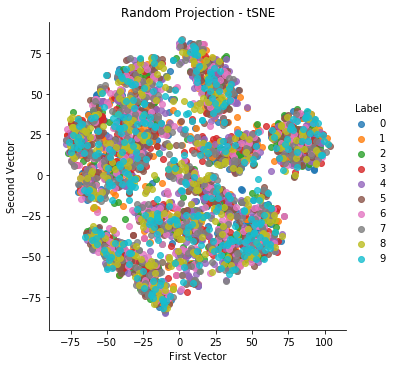

In [118]:
data = {'X': X_mnist_rp, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'Random Projection - tSNE')

In [45]:
mnist_rp = {"X": X_mnist_rp, "y": y_mnist_train, "name": "MNIST Random Projection"}
mnist_rp_bic, mnist_rp_score = build_gmm_data(mnist_rp)

Clusters:  2
BIC:            5590733.373177654
Log-likelihood: -56.24284974780289
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            5175874.944747878
Log-likelihood: -51.60682038898605
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            4972133.270685853
Log-likelihood: -49.125043625758515
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            4810620.876490192
Log-likelihood: -47.074177881575494
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            4710613.784307291
Log-likelihood: -45.65091725997167
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            4607050.638001798
Log-likelihood: -44.19137037181078
-

In [67]:
rp_bic= []
rp_score=[]
X = X_mnist_rp
print("="*100)
for i in range(12,15):
    print("Clusters: ", i)
    gm = GaussianMixture(n_components=i
                         ,n_init=10,
                         tol=1e-3,
                         max_iter=1000).fit(X)
    bic = gm.bic(X)
    score = gm.score(X)
    print("BIC:            {}".format(bic))
    print("Log-likelihood: {}".format(score))
    print("-"*100)
    rp_bic.append(bic)
    rp_score.append(score)

rp_bic, rp_score

Clusters:  12
BIC:            4289172.905284989
Log-likelihood: -38.93381959233956
----------------------------------------------------------------------------------------------------
Clusters:  13
BIC:            4275818.433198784
Log-likelihood: -38.394769379885695
----------------------------------------------------------------------------------------------------
Clusters:  14
BIC:            4263300.93020941
Log-likelihood: -37.864259668419905
----------------------------------------------------------------------------------------------------


([4289172.905284989, 4275818.433198784, 4263300.93020941],
 [-38.93381959233956, -38.394769379885695, -37.864259668419905])

In [82]:
full_rp_bic = mnist_rp_bic + [4289172.905284989, 4275818.433198784, 4263300.93020941]
full_rp_score = mnist_rp_score + [-38.93381959233956, -38.394769379885695, -37.864259668419905]

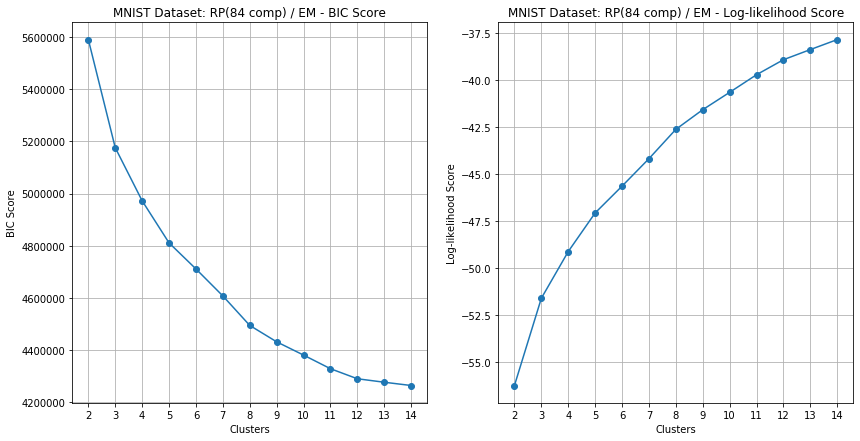

In [83]:
mtitle = "MNIST Dataset: RP(84 comp) / EM"
build_gmm_plots(mtitle, full_rp_bic, full_rp_score)

In [106]:
# 8 clusters Credit
Xm, ym, name = get_data(mnist_rp)
gm = GaussianMixture(n_components=8,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xm)

pred = gm.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, pred))

Adjusted Rand Score:      0.4560314896230429
Homogeneity Score:        0.6327893410175025
Calinski Harabasz Score:  1599.870505129414


# Dictionary Learning

In [113]:
Xm, ym, _ = get_data(mnist)

dl = MiniBatchDictionaryLearning(n_components=23,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
mnist_dl = dl.fit_transform(Xm)

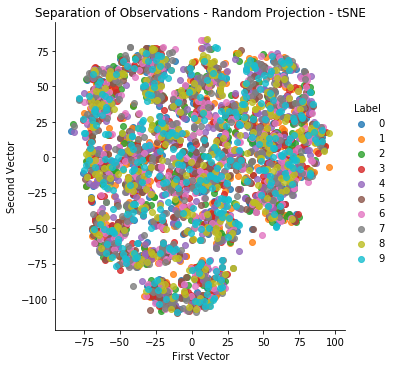

In [114]:
data = {'X': mnist_dl, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=30, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'Random Projection - tSNE')

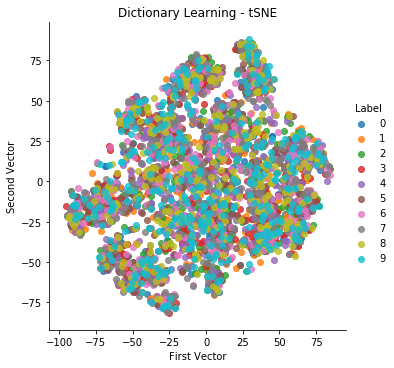

In [117]:
data = {'X': mnist_dl, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'Dictionary Learning - tSNE')

In [108]:
mnist_dl = {"X": mnist_dl, "y": y_mnist_train, "name": "MNIST Dict Learn"}
mnist_dl_bic, mnist_dl_score = build_gmm_data(mnist_dl)

Clusters:  2
BIC:            4619598.668181834
Log-likelihood: -47.07275226950159
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            4523773.543682454
Log-likelihood: -46.06188495141477
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            4305954.705396789
Log-likelihood: -43.80618381918219
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            4236768.573358633
Log-likelihood: -43.06714295478133
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            4182708.267142255
Log-likelihood: -42.482447251827196
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            4135033.362870224
Log-likelihood: -41.96290871157047
--

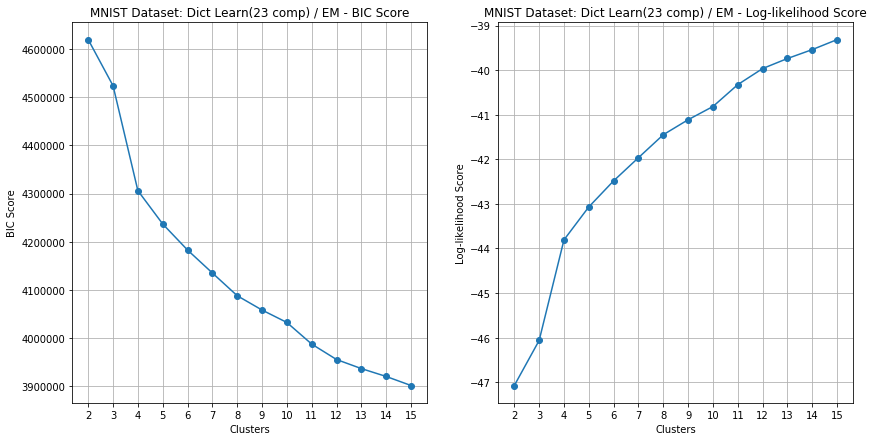

In [109]:
mtitle = "MNIST Dataset: Dict Learn(23 comp) / EM"
build_gmm_plots(mtitle, mnist_dl_bic, mnist_dl_score)

In [123]:
# 11 clusters Credit
Xm, ym, name = get_data(mnist)
gm = GaussianMixture(n_components=11,
                     n_init=10,
                     tol=1e-3,
                     max_iter=1000).fit(Xm)

pred = gm.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(pred, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, pred))

Adjusted Rand Score:      0.2574781947221823
Homogeneity Score:        0.39494460785295893
Calinski Harabasz Score:  945.4628199499418
